In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display
from collections import OrderedDict

In [2]:
df_train = pd.read_pickle('my_df_train.pickle')
df_test = pd.read_pickle('my_df_test.pickle')


(2513, 12)

In [8]:
# train
inj_vol = np.stack(df_train['inj_vol'].values)
# ignore neighbors and take data for the current co-ordinate
inj_vol = inj_vol[:,:,0]
pp = np.stack(df_train['pp'].values)
# ignore neighbors and take data for the current co-ordinate
pp = pp[:,:,0]
lat = np.stack(df_train['lat'].values)
lat = np.reshape(lat,(-1,1))
lon = np.stack(df_train['lon'].values)
lon = np.reshape(lon,(-1,1))



# dim: 2814 x 24
x_train = np.concatenate([lat, lon, inj_vol, pp], axis =1)
y_train = df_train['lambda'].values

# test
inj_vol = np.stack(df_test['inj_vol'].values)
# ignore neighbors and take data for the current co-ordinate
inj_vol = inj_vol[:,:,0]
pp = np.stack(df_test['pp'].values)
# ignore neighbors and take data for the current co-ordinate
pp = pp[:,:,0]
lat = np.stack(df_test['lat'].values)
lat = np.reshape(lat,(-1,1))
lon = np.stack(df_test['lon'].values)
lon = np.reshape(lon,(-1,1))


# dim: _ x 24
x_test = np.concatenate([lat, lon, inj_vol, pp], axis =1)
y_test = df_test['lambda'].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(2513, 26) (2513,)
(729, 26) (729,)


In [9]:
import torch 
from torch import nn

class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        # create layers
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, 1)
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return output

In [10]:
# convert train test data to torch tensors
X_train = torch.from_numpy(x_train.astype('float32'))
Y_train = torch.from_numpy(np.expand_dims(y_train, axis=-1).astype('float32'))
X_test = torch.from_numpy(x_test.astype('float32'))
Y_test = torch.from_numpy(np.expand_dims(y_test, axis=-1).astype('float32'))

In [11]:
print(X_train.shape, Y_train.shape, X_train.dtype, Y_train.dtype)
print(X_test.shape, Y_test.shape, X_test.dtype, Y_test.dtype)


torch.Size([2513, 26]) torch.Size([2513, 1]) torch.float32 torch.float32
torch.Size([729, 26]) torch.Size([729, 1]) torch.float32 torch.float32


In [25]:
# set random seed for initializing model weights
torch.manual_seed(12345)
model = Feedforward(x_train.shape[1], 32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)


In [26]:
model.train()
loss_train_array = []
loss_test_array = []
epoch = 2500
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    loss_train = loss_fn(model(X_train), Y_train)
    loss_train_array.append(loss_train)
    loss_test = loss_fn(model(X_test), Y_test)
    loss_test_array.append(loss_test)

   
    print('Epoch %s: train loss: %6.4f, test loss %6.4f'%(epoch, loss_train.item(), loss_test.item()))
    # Backward pass
    loss_train.backward()
    optimizer.step()




Epoch 0: train loss: 4.6124, test loss 14.5746
Epoch 1: train loss: 44.8418, test loss 73.5516
Epoch 2: train loss: 5.5058, test loss 20.8734
Epoch 3: train loss: 4.9644, test loss 14.5657
Epoch 4: train loss: 15.7501, test loss 25.4147
Epoch 5: train loss: 13.7892, test loss 22.8569
Epoch 6: train loss: 6.1568, test loss 13.8823
Epoch 7: train loss: 1.1472, test loss 8.0296
Epoch 8: train loss: 1.0684, test loss 7.8472
Epoch 9: train loss: 3.7159, test loss 10.9302
Epoch 10: train loss: 5.7694, test loss 13.2293
Epoch 11: train loss: 5.6091, test loss 12.7963
Epoch 12: train loss: 3.7658, test loss 10.2622
Epoch 13: train loss: 1.7030, test loss 7.3752
Epoch 14: train loss: 0.5699, test loss 5.4901
Epoch 15: train loss: 0.6477, test loss 5.0457
Epoch 16: train loss: 1.4650, test loss 5.5424
Epoch 17: train loss: 2.2848, test loss 6.1647
Epoch 18: train loss: 2.5869, test loss 6.3297
Epoch 19: train loss: 2.2720, test loss 5.9086
Epoch 20: train loss: 1.5812, test loss 5.1506
Epoch 21:

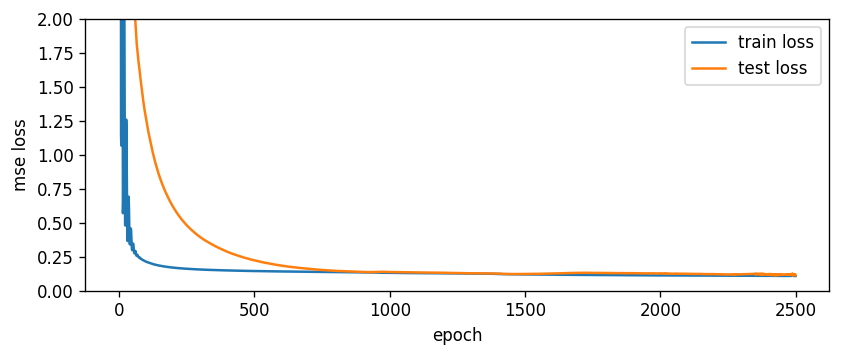

In [27]:
plt.figure(figsize=(8,3), dpi=120)
plt.plot(loss_train_array)
plt.plot(loss_test_array)
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.ylim([0,2])
plt.show()

# Training and testing for each cordinate

In [28]:
model.eval()
X_pred = model(X_test)



In [29]:
df_test['Pred'] = X_pred.detach().numpy()

In [30]:

loss_co_ord = OrderedDict()
for co_ord, df_c in df_test.groupby(['lat','lon']):
    loss = (df_c['Pred'] - df_c['lambda'])**2
    loss_co_ord[str(co_ord)] = loss
    # loss_co_ord.append(loss.detach().item())

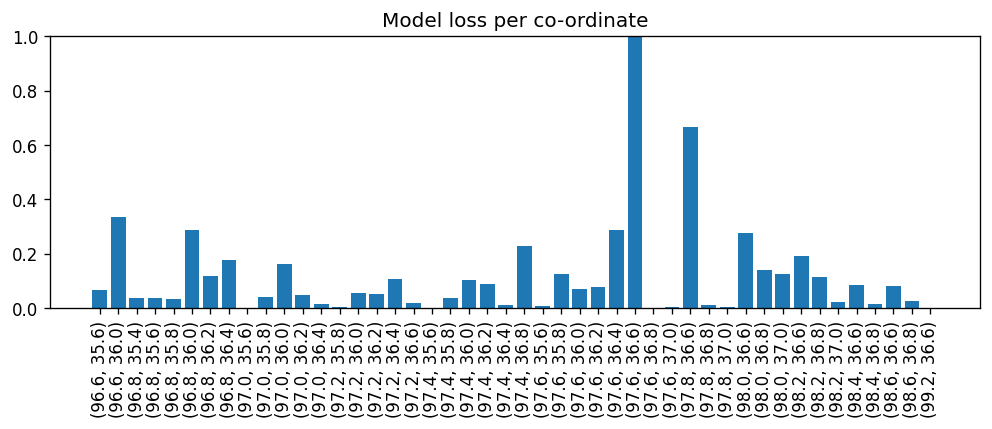

In [31]:
plt.figure(figsize=(10,3), dpi=120)
plt.bar(loss_co_ord.keys(), [x.mean() for x in loss_co_ord.values()])
# notch shape box plot
# plt.boxplot(loss_co_ord.values(),
#                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=loss_co_ord.keys())  # will be used to label x-ticks
plt.ylim([0,1])
plt.xticks(rotation=90)
plt.title('Model loss per co-ordinate')
plt.show()